# Clustering

### Skip this part (use of fasttext)

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.decomposition import PCA as sklearnPCA

In [38]:
from __future__ import print_function
from gensim.models import KeyedVectors

# Creating the model
en_model = KeyedVectors.load_word2vec_format('../data/fasttext/crawl-300d-2M-subword.vec')

# Getting the tokens 
words = []
for word in en_model.vocab:
    words.append(word)

# Printing out number of tokens available
print("Number of Tokens: {}".format(len(words)))

# Printing out the dimension of a word vector 
print("Dimension of a word vector: {}".format(
    len(en_model[words[0]])
))


2019-03-08 07:34:38,374 : INFO : loading projection weights from ../data/fasttext/crawl-300d-2M-subword.vec
2019-03-08 07:43:45,684 : INFO : loaded (2000000, 300) matrix from ../data/fasttext/crawl-300d-2M-subword.vec


Number of Tokens: 2000000
Dimension of a word vector: 300


In [47]:
find_similar_to = 'mathematical'

# Finding out similar words [default= top 10]
for similar_word in en_model.similar_by_word(find_similar_to):
    print("Word: {0}, Similarity: {1:.2f}".format(
        similar_word[0], similar_word[1]
    ))
model  = en_model   
model.wv.in

Word: mathematic, Similarity: 0.88
Word: mathematically-based, Similarity: 0.80
Word: non-mathematical, Similarity: 0.79
Word: mathematics, Similarity: 0.78
Word: mathmatical, Similarity: 0.78
Word: algebraic, Similarity: 0.77
Word: arithmetical, Similarity: 0.77
Word: mathemagical, Similarity: 0.76
Word: Mathematical, Similarity: 0.76
Word: mathematics-based, Similarity: 0.76


# From Here

In [2]:
import io
import os
from os import path, listdir
import pandas as pd
from gensim.corpora import Dictionary
import numpy as np
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from gensim.models import doc2vec
from collections import namedtuple
import nltk
from nltk.cluster import KMeansClusterer
import scipy.spatial.distance as ssd
from sklearn import metrics
import pickle
import glob

import utils
import importlib
importlib.reload(utils)

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
dfMap = pd.read_csv("mapping.csv")
#print(dfMap)
file2tag = {f:t for f,t in zip(dfMap["name"],dfMap["id"])}
tag2file = {t:f for t,f in zip(dfMap["id"],dfMap["name"])}
print("Name of file with id = {0} is {1}".format(35,tag2file[35]))
print("ID of file with name = {0} is {1}".format("puchinger-05", file2tag["puchinger-05"]))

Name of file with id = 35 is caserta-14
ID of file with name = puchinger-05 is 6


In [4]:
analyzedDocument = namedtuple('AnalyzedDocument','words tags')
year0 = "2001"
yearT = "2019"
yearSet = list(range(int(year0), int(yearT)+1))

corpus = []

for year in yearSet:
    
    listOfFiles = glob.glob(path.join(utils.Config.prefix,utils.Config.p_dir,str(year),"*.p"))

    for pFile in listOfFiles:

        #print("Opening FILE = ", pdfFile)
        filename = os.path.basename(pFile)
        name, file_extension = os.path.splitext(filename)
        ff = path.join(utils.Config.p_dir, str(year), filename)
        print("Processing file '{0}'".format(ff))
        doc = pickle.load(open(ff, 'rb'))
        tags = [str(file2tag[name])]
        print("... TAG = ", tags, " :: document length = ", len(doc), "words.")
        corpus.append(analyzedDocument(doc,tags))
        #input("aka")
print("Loaded corpus with", len(corpus), "documents.")



Processing file 'data/p/2001/taillard-01.p'
... TAG =  ['0']  :: document length =  1999 words.
Processing file 'data/p/2001/hansen-01.p'
... TAG =  ['1']  :: document length =  2141 words.
Processing file 'data/p/2003/dumitrescu-03.p'
... TAG =  ['2']  :: document length =  5722 words.
Processing file 'data/p/2003/fischetti-03.p'
... TAG =  ['3']  :: document length =  3153 words.
Processing file 'data/p/2004/fischetti-04.p'
... TAG =  ['4']  :: document length =  2680 words.
Processing file 'data/p/2005/danna-05.p'
... TAG =  ['5']  :: document length =  3915 words.
Processing file 'data/p/2005/puchinger-05.p'
... TAG =  ['6']  :: document length =  2184 words.
Processing file 'data/p/2006/sniedovich-06.p'
... TAG =  ['7']  :: document length =  3784 words.
Processing file 'data/p/2006/hansen-06.p'
... TAG =  ['8']  :: document length =  1892 words.
Processing file 'data/p/2007/boschetti-07.p'
... TAG =  ['10']  :: document length =  3999 words.
Processing file 'data/p/2007/rothberg-

... TAG =  ['155']  :: document length =  4445 words.
Processing file 'data/p/2018/dupin-18.p'
... TAG =  ['116']  :: document length =  4969 words.
Processing file 'data/p/2018/regis-18.p'
... TAG =  ['137']  :: document length =  3803 words.
Processing file 'data/p/2018/woo-18.p'
... TAG =  ['146']  :: document length =  4639 words.
Processing file 'data/p/2018/agra-18.p'
... TAG =  ['132']  :: document length =  3990 words.
Processing file 'data/p/2018/sadykov-18.p'
... TAG =  ['156']  :: document length =  5147 words.
Processing file 'data/p/2018/caserta-18.p'
... TAG =  ['111']  :: document length =  4293 words.
Processing file 'data/p/2018/hojabri.p'
... TAG =  ['128']  :: document length =  3107 words.
Processing file 'data/p/2018/hitoshi-18.p'
... TAG =  ['112']  :: document length =  7288 words.
Processing file 'data/p/2018/moench-18.p'
... TAG =  ['114']  :: document length =  4424 words.
Processing file 'data/p/2018/calvete-18.p'
... TAG =  ['140']  :: document length =  251

In [5]:
fullname = path.join(utils.Config.models_dir,utils.Config.nameModel)
print("Loading model ", fullname)
model = doc2vec.Doc2Vec.load(fullname)
print("The model contains {0} vectors.".format(len(model.docvecs)))

2019-03-11 14:54:12,369 : INFO : loading Doc2Vec object from models/doc2vec.model


Loading model  models/doc2vec.model


2019-03-11 14:54:12,632 : INFO : loading wv recursively from models/doc2vec.model.wv.* with mmap=None
2019-03-11 14:54:12,633 : INFO : loading docvecs recursively from models/doc2vec.model.docvecs.* with mmap=None
2019-03-11 14:54:12,634 : INFO : loading vocabulary recursively from models/doc2vec.model.vocabulary.* with mmap=None
2019-03-11 14:54:12,635 : INFO : loading trainables recursively from models/doc2vec.model.trainables.* with mmap=None
2019-03-11 14:54:12,636 : INFO : loaded models/doc2vec.model


The model contains 473 vectors.


In [7]:
withTest = 1
if withTest:
    x = []
    for idx in range(len(corpus)):
        v0 = model.infer_vector(corpus[idx].words, steps=100)
        sims = model.docvecs.most_similar([v0], topn=len(corpus))
        rank = [idx for idx,sim in sims].index(str(idx))
        x.append(rank)
        #if idx % 5 == 0:
        print("Vector ", idx, " has rank ", rank)

Vector  0  has rank  0
Vector  1  has rank  0
Vector  2  has rank  1


KeyboardInterrupt: 

In [6]:
vecs = []
count = 0
for tag in dfMap["id"]:
    if count % 25 == 0:
        print("Processing document ", tag)
    #v0 = model.docvecs[tag]
    v0 = model.infer_vector(corpus[tag].words, steps=100)
    vecs.append(v0)  
    count += 1
print("Done.")   

Processing document  0
Processing document  25
Processing document  50
Processing document  75
Processing document  100
Processing document  125
Processing document  150
Processing document  175
Done.


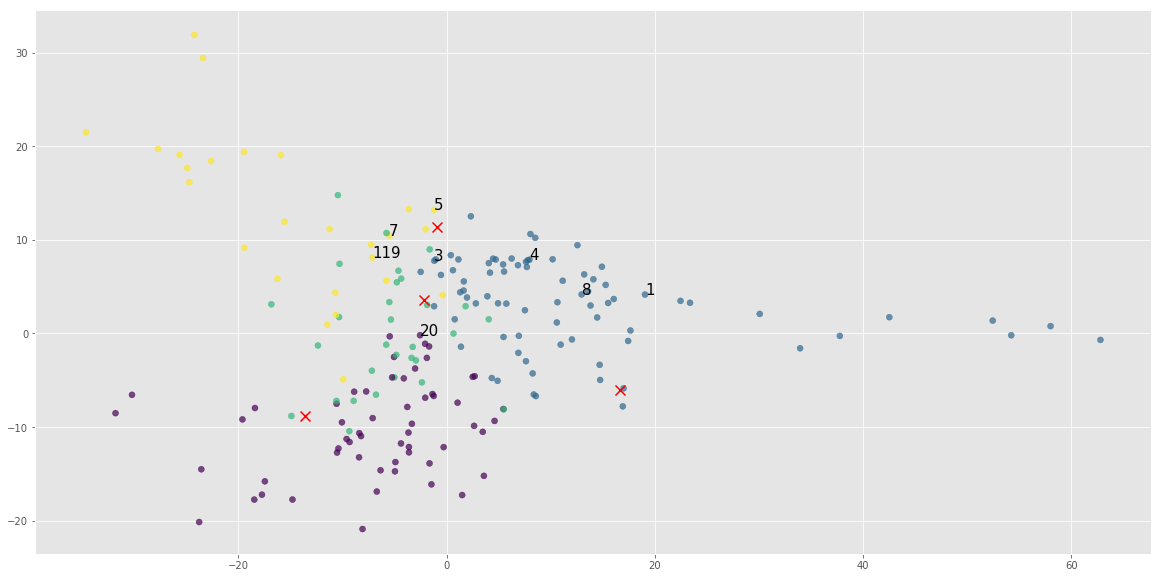

In [10]:
subset = [0,1,3,4,5,7,8,20,119] # 0 removed

pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(vecs))

fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(transformed[0], transformed[1], c=labels, alpha=0.7)

centers = pd.DataFrame(pca.fit_transform(means))
plt.scatter(centers[0], centers[1], c="red", s=100, marker="x")
#for idx in dfMap["id"]:
for idx in subset:
    ax.annotate(str(idx), (transformed[0][idx], transformed[1][idx]), fontsize=15)
plt.show()

## K-mean Clustering

In [9]:
from nltk.cluster import KMeansClusterer

In [7]:
def nltkClustering(vectors, nrClusters, repeats):
    """
    Use the clustering function of NLTK. The algorithm is applied on the set of vectors contained in the 
    datastructure `vectors`.
    """

    num_clusters = nrClusters
    kclusterer = KMeansClusterer(num_clusters, 
        #distance = nltk.cluster.util.cosine_distance,
        distance = nltk.cluster.util.euclidean_distance,
        repeats = repeats)
    labels = kclusterer.cluster(vectors, assign_clusters=True)
    score = metrics.silhouette_score(vectors, labels, metric="cosine")
    ch = metrics.calinski_harabaz_score(vectors, labels)
    means = kclusterer.means()
    print("Silhouette score (nc = {0:3d}) = {1:8.5f}. Calinski-Harabaz Score = {2:8.5f}".format(nrClusters, score,ch))

    return labels, score, ch, means

In [8]:
print(len(vecs))
for nc in range(3,10):
    label, score, ch, means = nltkClustering(vecs, nrClusters = nc, repeats=200)


190
Silhouette score (nc =   3) =  0.03517. Calinski-Harabaz Score =  8.76329
Silhouette score (nc =   4) =  0.02982. Calinski-Harabaz Score =  7.25653
Silhouette score (nc =   5) =  0.02908. Calinski-Harabaz Score =  7.07230
Silhouette score (nc =   6) =  0.01884. Calinski-Harabaz Score =  5.45614
Silhouette score (nc =   7) =  0.02004. Calinski-Harabaz Score =  5.17292
Silhouette score (nc =   8) =  0.02080. Calinski-Harabaz Score =  4.89183
Silhouette score (nc =   9) = -0.00789. Calinski-Harabaz Score =  4.40633


In [71]:
for nc in range(10,20):
    label, score, ch, means = nltkClustering(vecs, nrClusters = nc, repeats=50)

Silhouette score (nc =  10  ) =  -0.0423993
Silhouette score (nc =  11  ) =  -0.01067
Silhouette score (nc =  12  ) =  -0.0135621
Silhouette score (nc =  13  ) =  -0.0444899
Silhouette score (nc =  14  ) =  -0.00254362
Silhouette score (nc =  15  ) =  -0.0451179
Silhouette score (nc =  16  ) =  -0.02658
Silhouette score (nc =  17  ) =  -0.0178666
Silhouette score (nc =  18  ) =  -0.0194981
Silhouette score (nc =  19  ) =  -0.0228505


In [86]:
labels, score, ch, means = nltkClustering(vecs, nrClusters = 3, repeats=50)

Silhouette score (nc =  3  ) =  0.0445612


In [9]:
labels, score, ch, means = nltkClustering(vecs, nrClusters = 4, repeats=200)

Silhouette score (nc =   4) =  0.04459. Calinski-Harabaz Score =  7.48244


Compute distance of each document to the center of its cluster.

In [100]:
def compute_distances(tags, labels, means, vecs):
    dists = []
    for tag,lab,vv in zip(tags, labels, vecs):
        meanVec = means[lab]
        dd = ssd.cosine(vv,meanVec)
        dists.append(dd)
    return dists


In [169]:
dists = compute_distances(dfMap["id"], labels, means, vecs)

In [170]:
df = pd.DataFrame({
    "id" : dfMap["id"],
    "name": dfMap["name"],
    "clusters": labels,
    "distance": dists
})
print(df.head())
df.to_csv("data/clustersNltk.csv")

   clusters  distance  id           name
0         1  0.091041   0    taillard-01
1         1  0.101492   1      hansen-01
2         2  0.056678   2  dumitrescu-03
3         2  0.066550   3   fischetti-03
4         1  0.077153   4   fischetti-04


Most similar words to cluster centers.

In [38]:
clusters = list(set(labels))
nClusters = len(clusters)
for cc in clusters:
    print("Cluster ", cc)
    mm = model.wv.similar_by_vector(means[cc], topn=30)
    print(mm)

Cluster  0
[('aziz', 0.3254750967025757), ('symposium', 0.2903754711151123), ('hosting', 0.27444127202033997), ('valerie', 0.27270638942718506), ('angel', 0.2535954713821411), ('ettore', 0.24598684906959534), ('nanomedicine', 0.2454141527414322), ('poisson', 0.23141519725322723), ('regis', 0.22857046127319336), ('hygiene', 0.22117111086845398), ('oppermann', 0.21342733502388), ('belfort', 0.21286557614803314), ('nickel', 0.2111763060092926), ('sorbonne', 0.2101992666721344), ('saturation', 0.20825961232185364), ('paul', 0.19986316561698914), ('disability', 0.18745474517345428), ('citation', 0.18718472123146057), ('consiglio', 0.185280904173851), ('icd', 0.18509499728679657), ('compiegne', 0.1766752004623413), ('nazionale', 0.1764272302389145), ('marie', 0.17572179436683655), ('istituto', 0.17105886340141296), ('eager', 0.16977626085281372), ('copyright', 0.16957856714725494), ('milan', 0.16647621989250183), ('united', 0.16431358456611633), ('asd', 0.163843035697937), ('clash', 0.161519

## Working on a subset of documents

The idea is to select a subset of papers, i.e., those associated to the presentation of a general matheuristics, and work on them. We want to create a full distance matrix as well as a clustering solution.

['taillard-01', 'hansen-01', 'fischetti-03', 'fischetti-04', 'danna-05', 'sniedovich-06', 'hansen-06', 'angeletti-10', 'taillard-18']
9
Silhouette score (nc =   2) =  0.06275. Calinski-Harabaz Score =  2.11868
Best solution with 2 clusters.
Silhouette score (nc =   3) =  0.06870. Calinski-Harabaz Score =  2.16972
Best solution with 3 clusters.
Silhouette score (nc =   4) =  0.08319. Calinski-Harabaz Score =  2.71712
Best solution with 4 clusters.
Silhouette score (nc =   5) =  0.04408. Calinski-Harabaz Score =  2.37267


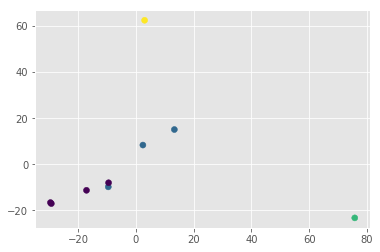

In [23]:
subset = [0,1,3,4,5,7,8,20,119]
subnames = [dfMap["name"].loc[i] for i in subset]
print(subnames)
subvecs = [vecs[i] for i in subset]
print(len(subvecs))
bestScore = -1.0
for nc in range(2,6):
    sublabel, score, ch, submeans = nltkClustering(subvecs, nrClusters = nc, repeats=200)
    if score > bestScore:
        bestScore = score
        bestLabels = sublabel
        print("Best solution with {0} clusters.".format(nc))

pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(subvecs))
plt.scatter(transformed[0], transformed[1], c=bestLabels)
plt.show()

In [191]:
dists = compute_distances(subset, bestLabels, submeans, subvecs)
df = pd.DataFrame({
    "id" : subset,
    "name": subnames,
    "clusters": bestLabels,
    "distance": dists
})
print(df)

   clusters      distance   id           name
0         0  1.558822e-01    0    taillard-01
1         0  1.627910e-01    1      hansen-01
2         1  7.520525e-02    3   fischetti-03
3         1  5.557095e-02    4   fischetti-04
4         1  1.239442e-01    5       danna-05
5         2  2.303253e-01    7  sniedovich-06
6         0  1.363392e-01    8      hansen-06
7         0  1.034675e-07   20   angeletti-10
8         1  1.594130e-01  119    taillard-18


## DBClustering

The advantage of this method is that it does not force every point of the set to be assigned to a cluster. Some points can be treated as "noise" and are left out from the assignment. This sounds like a good idea, since it might find that only some of the users are grouped together.

There are basically two versions of these types of clustering algorithms:
- non-hierarchical: DBSCAN
- hierarchical : HDBSCAN

Below, I use both of them. As we can see, the results lead to a non-meaningful assigment. Only one cluster is created, regardless of which method and metric are used. 

In [112]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [154]:
#X = StandardScaler().fit_transform(vecs)

algos = ['auto', 'ball_tree', 'kd_tree', 'brute']
all_metrics = ['cosine', 'euclidean', 'correlation', 'matching']

# Compute DBSCAN
for algo in algos:
    for mm in all_metrics:
        X = vecs
        try:
            db = DBSCAN(eps=1, min_samples=2, n_jobs=-1, algorithm=algo, metric=mm).fit(X)
        except:
            continue
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        #print(labels)
        try:
            score = metrics.silhouette_score(X, labels, metric=mm)
            ch = metrics.calinski_harabaz_score(vectors, labels)
        except:
            score = 0.0
            ch    = -9.9999
        print("Algo = {0}\t Metric = {1}\t Nr.Cluster = {2:3d}, Silhouette = {3:8.5f} Calinski-Harabasz = {4:8.5f}".format(algo, mm, n_clusters_, score, ch))

Algo = auto	 Metric = cosine	 Nr.Cluster =   1, Silhouette =  0.00000 Calinski-Harabasz = -9.99990
Algo = auto	 Metric = euclidean	 Nr.Cluster =   0, Silhouette =  0.00000 Calinski-Harabasz = -9.99990
Algo = auto	 Metric = correlation	 Nr.Cluster =   1, Silhouette =  0.00000 Calinski-Harabasz = -9.99990
Algo = auto	 Metric = matching	 Nr.Cluster =   1, Silhouette =  0.00000 Calinski-Harabasz = -9.99990
Algo = ball_tree	 Metric = euclidean	 Nr.Cluster =   0, Silhouette =  0.00000 Calinski-Harabasz = -9.99990
Algo = ball_tree	 Metric = matching	 Nr.Cluster =   1, Silhouette =  0.00000 Calinski-Harabasz = -9.99990
Algo = kd_tree	 Metric = euclidean	 Nr.Cluster =   0, Silhouette =  0.00000 Calinski-Harabasz = -9.99990
Algo = brute	 Metric = cosine	 Nr.Cluster =   1, Silhouette =  0.00000 Calinski-Harabasz = -9.99990
Algo = brute	 Metric = euclidean	 Nr.Cluster =   0, Silhouette =  0.00000 Calinski-Harabasz = -9.99990
Algo = brute	 Metric = correlation	 Nr.Cluster =   1, Silhouette =  0.000

/home/mcaserta/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype float32 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Algo = brute	 Metric = matching	 Nr.Cluster =   1, Silhouette =  0.00000 Calinski-Harabasz = -9.99990


## HDBClustering

A hierarchical clustering algorithm based on DBClustering.

In [99]:
import hdbscan
from sklearn.datasets import make_blobs

In [100]:
blobs, labels = make_blobs(n_samples=2000, n_features=10)
pd.DataFrame(blobs).head()

,0,1,2,3,4,5,6,7,8,9
0,8.383156,-8.277472,-1.806924,-4.294713,8.048482,-8.736692,-5.298942,-7.140613,-1.446901,7.622145
1,7.820244,5.547277,-7.719892,10.660296,0.642026,-3.129945,5.104059,7.108933,-4.469921,7.653229
2,9.353370,3.941909,-6.619772,9.697384,1.642578,-3.685025,4.994648,5.875471,-5.046464,6.239185
3,9.904518,5.838807,-6.097169,9.411649,1.604958,-3.310898,5.262367,8.806206,-5.563347,6.135471
4,-8.013914,4.779585,7.413801,9.820288,10.244152,5.213157,-10.519504,-0.609937,7.631231,-9.745499


In [101]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, algorithm='prims_kdtree')
clusterer.fit(blobs)

HDBSCAN(algorithm='prims_kdtree', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=3, min_samples=None, p=None,
    prediction_data=False)

In [102]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [103]:
X = StandardScaler().fit_transform(vecs)

In [104]:
db = DBSCAN(eps=0.3, min_samples=5, n_jobs=-1, algorithm="kd_tree").fit(vecs)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [105]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(labels)
print(n_clusters_)
score = metrics.silhouette_score(vecs, labels, metric="cosine")
print("Silhouette score = ", score )


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

## Hierarchical Clustering

In [106]:
import collections
import scipy.spatial.distance as ssd
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet

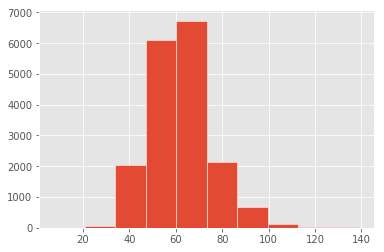

In [107]:
distMatrix = [ [0.0 for i in range(len(vecs))] for j in range(len(vecs))]
dd = cdist(vecs, vecs)
distArray = ssd.squareform(np.asmatrix(dd), checks = False)
# distribution of pairwise distances
plt.hist(distArray, edgecolor="white")
plt.show()

In [109]:
# Find the best hierarchical clustering method
methods = ["ward", "median", "average", "single", "complete"]
bestVal = 0.0
bestMethod = " "
for mm in methods:
    Z = linkage(distArray, method=mm)
    c, cophDist = cophenet(Z, distArray)
    print("[ {0:10s}] Cophenetic = {1:5.2f}".format(mm,c))
    if c > bestVal:
        bestVal = c
        bestMethod = mm
        
#Z = linkage(distArray, method=bestMethod, optimal_ordering=True)
print("Best method is '", bestMethod, "' with best cophenet value = ", bestVal)
Z = linkage(distArray, method=bestMethod)

[ ward      ] Cophenetic =  0.43
[ median    ] Cophenetic =  0.78
[ average   ] Cophenetic =  0.84
[ single    ] Cophenetic =  0.77
[ complete  ] Cophenetic =  0.67
Best method is ' average ' with best cophenet value =  0.837749489526


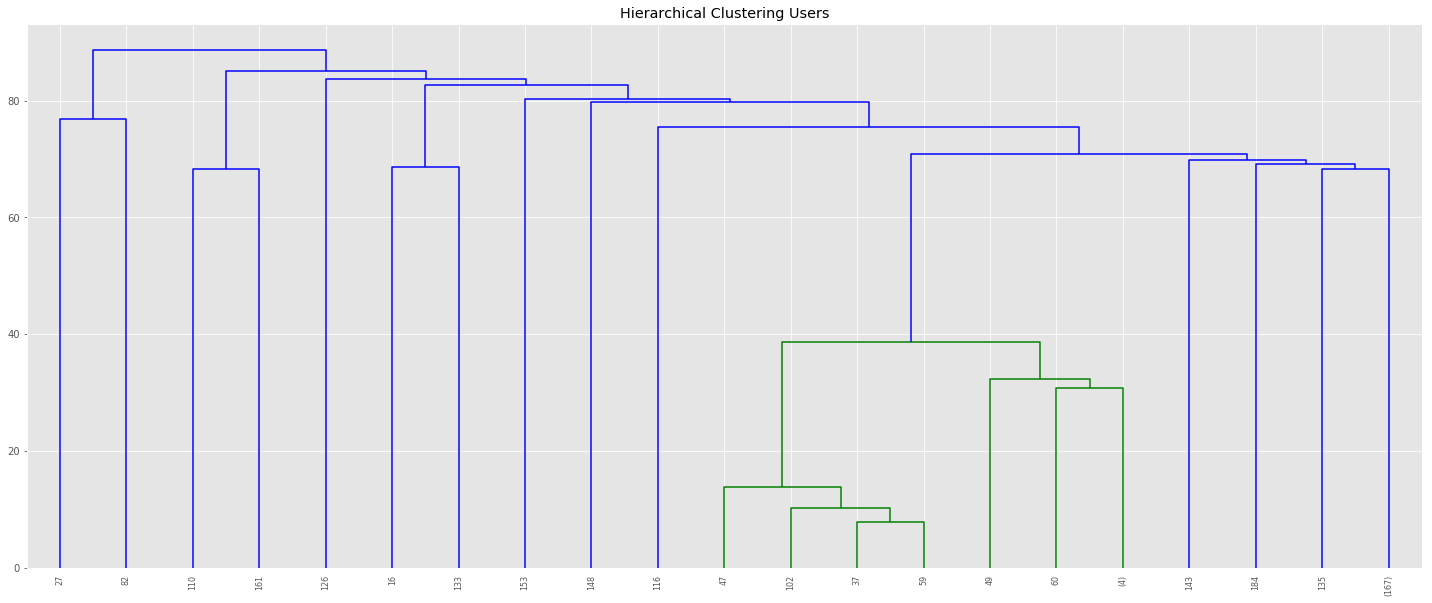

In [113]:
plt.figure(figsize=(25,10))
plt.title("Hierarchical Clustering Users")
pp= dendrogram(
    Z,
    leaf_rotation=90,
    leaf_font_size=8.,
    show_leaf_counts=True,
    get_leaves=True,
    truncate_mode="level",
    p = 10
)
plt.show()

In [118]:
maxD = 60 # increase maxD to reduce depth.Therefore, the number of clusters created gets reduced
labels = fcluster(Z, maxD, criterion="distance")
labels = labels - [1]*len(labels)
print("Length labels vs idOriginal vs vecs", len(labels), len(dfMap["id"]), len(vecs))

Length labels vs idOriginal vs vecs 190 190 190


Counter({27: 127, 6: 10, 16: 5, 21: 2, 24: 2, 25: 2, 26: 2, 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 17: 1, 18: 1, 19: 1, 20: 1, 22: 1, 23: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1})


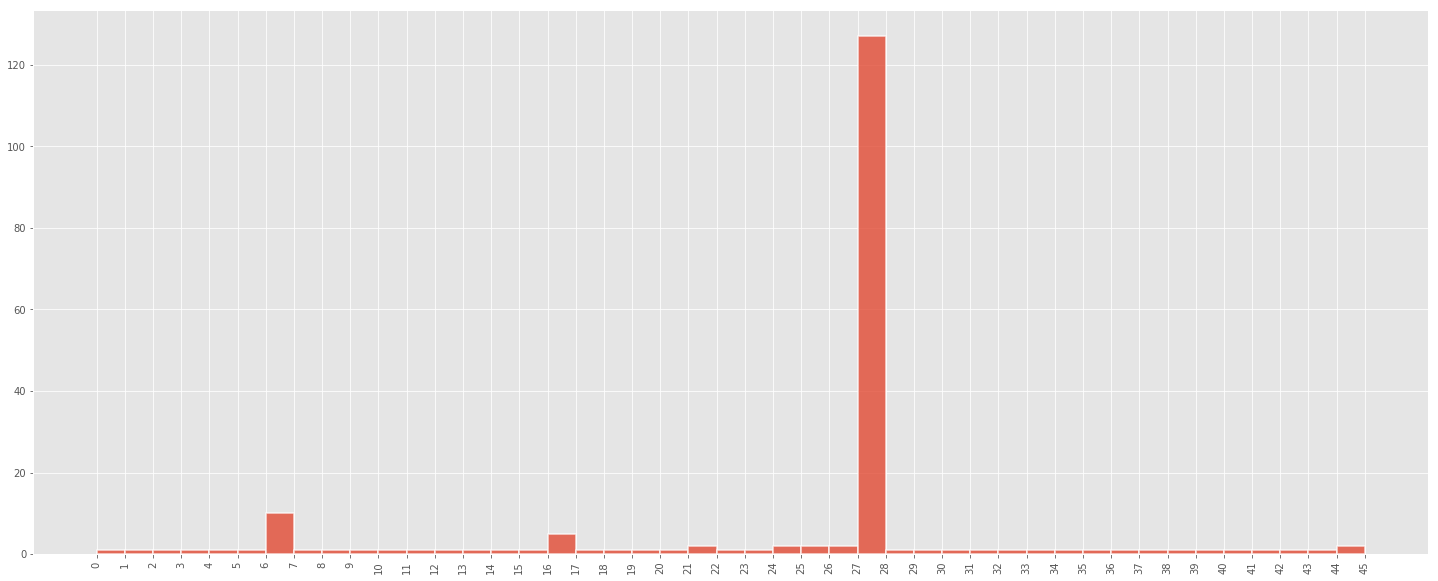

In [119]:
plt.figure(figsize=(25,10))
counter=collections.Counter(labels)
print(counter)
bins = np.arange(min(labels),max(labels))
plt.hist(labels, edgecolor="white", bins=bins, linewidth=1.5, alpha=0.8)
if len(bins) > 25:
    rotation="vertical"
else:
    rotation="horizontal"
plt.xticks(np.round(bins,0), rotation=rotation)
plt.show()